# Домашнее задание
1. Модифицируйте код из туториала ниже, чтобы **достичь наибольшего качества классификации на датасете FashionMNIST** при помощи нейронной сети. Вы можете попробовать:
- Изменить архитектуру нейросети: добавить слои или изменить количество нейронов в каждом слое, функции активации
- Изменить значения гиперпараметров: learning_rate, количество эпох, оптимизатор

2. Постройте матрицу ошибок (confusion matrix) для вашего классификатора и простой полносвязной нейросети из примера. Какие классы чаще всего путают модели?

\* Выходы последнего слоя нейросети отражают информацию о входных объектах. Их можно использовать как признаки для других задач. После тренировки нейросети извлеките эти значения для каждой картинки в датасете и **постройте визуализацию картинок при помощи UMAP**. Окрасьте изображение по классам картинок. Видно ли в нём дополнительную структуру в данных?

\*\* Сделайте визуализацию UMAP по картинкам, выпрямленным в вектора без обработки нейросетью. Сравните с результатами предыдущего шага. Какие классы похожи друг на друга?

3. Вы уже реализовывали логистическую регрессию в домашнем задании по классификации. Сделайте это снова при помощи библиотеки Pytorch. **Реализуйте логистическую регрессию как нейрон и обучите его**. Проверьте качество на тем же данным по [покемонам](https://www.kaggle.com/datasets/abcsds/pokemon), что и в домашнем задании 14 дня.

4. \* Реализуйте модель регрессии для предсказания цены жилья ("median_house_value") в датасете california_housing.
В качестве функции ошибок можно выбрать MSE. Если вы работаете в google colab, данные можно найти в папке `sample_data`.



[Learn the Basics](intro.html) \|\| **Quickstart** \|\|
[Tensors](tensorqs_tutorial.html) \|\| [Datasets &
DataLoaders](data_tutorial.html) \|\|
[Transforms](transforms_tutorial.html) \|\| [Build
Model](buildmodel_tutorial.html) \|\|
[Autograd](autogradqs_tutorial.html) \|\|
[Optimization](optimization_tutorial.html) \|\| [Save & Load
Model](saveloadrun_tutorial.html)

Quickstart
==========

This section runs through the API for common tasks in machine learning.
Refer to the links in each section to dive deeper.

Working with data
-----------------

PyTorch has two [primitives to work with
data](https://pytorch.org/docs/stable/data.html):
`torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset`
stores the samples and their corresponding labels, and `DataLoader`
wraps an iterable around the `Dataset`.


In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.functional import F


PyTorch offers domain-specific libraries such as
[TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and
[TorchAudio](https://pytorch.org/audio/stable/index.html), all of which
include datasets. For this tutorial, we will be using a TorchVision
dataset.

The `torchvision.datasets` module contains `Dataset` objects for many
real-world vision data like CIFAR, COCO ([full list
here](https://pytorch.org/vision/stable/datasets.html)). In this
tutorial, we use the FashionMNIST dataset. Every TorchVision `Dataset`
includes two arguments: `transform` and `target_transform` to modify the
samples and labels respectively.


In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:02<00:00, 10985875.96it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212562.45it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3929495.69it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13726813.09it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



We pass the `Dataset` as an argument to `DataLoader`. This wraps an
iterable over our dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading. Here we define a batch size of
64, i.e. each element in the dataloader iterable will return a batch of
64 features and labels.


In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Read more about [loading data in PyTorch](data_tutorial.html).


------------------------------------------------------------------------


Creating Models
===============

To define a neural network in PyTorch, we create a class that inherits
from
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
We define the layers of the network in the `__init__` function and
specify how data will pass through the network in the `forward`
function. To accelerate operations in the neural network, we move it to
the GPU or MPS if available.


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
neurons_q = 512
neurons_q_2 = 1024


linear_relu_stack_1 = nn.Sequential(nn.Linear(28*28, neurons_q),
                                    nn.ReLU(),
                                    nn.Linear(neurons_q, neurons_q),
                                    nn.ReLU(),nn.Linear(neurons_q, 10))


In [6]:
linear_relu_stack_2 = nn.Sequential(nn.Linear(28*28, neurons_q_2),
                                    nn.ReLU(),
                                    nn.Linear(neurons_q_2, neurons_q_2),
                                    nn.ReLU(),
                                    nn.Linear(neurons_q_2, neurons_q_2),
                                    nn.ReLU(),
                                    nn.Linear(neurons_q_2, neurons_q_2),
                                    nn.ReLU(),
                                    nn.Linear(neurons_q_2, 10))

In [7]:

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, linear_relu_stack):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = linear_relu_stack

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        n_conv_kernels_1 = 32
        n_conv_kernels_2 = 64
        n_linear_neurons = 512

        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, n_conv_kernels_1, kernel_size=3, stride=1, padding=1), # Input: 1 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 32 x 14 x 14

            nn.Conv2d(n_conv_kernels_1, n_conv_kernels_2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: 64 x 7 x 7
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_conv_kernels_2 * 7 * 7, n_linear_neurons),
            nn.ReLU(),
            nn.Linear(n_linear_neurons, 10) # For 10 classes
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork(linear_relu_stack_1).to(device)
model_2 = NeuralNetwork(linear_relu_stack_2).to(device)
print(model_2)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=10, bias=True)
  )
)


Read more about [building neural networks in
PyTorch](buildmodel_tutorial.html).


------------------------------------------------------------------------


Optimizing the Model Parameters
===============================

To train a model, we need a [loss
function](https://pytorch.org/docs/stable/nn.html#loss-functions) and an
[optimizer](https://pytorch.org/docs/stable/optim.html).


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training
dataset (fed to it in batches), and backpropagates the prediction error
to adjust the model\'s parameters.


In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model\'s performance against the test dataset to
ensure it is learning.


In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*).
During each epoch, the model learns parameters to make better
predictions. We print the model\'s accuracy and loss at each epoch;
we\'d like to see the accuracy increase and the loss decrease with every
epoch.


In [11]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306166  [   64/60000]
loss: 2.291260  [ 6464/60000]
loss: 2.276616  [12864/60000]
loss: 2.265946  [19264/60000]
loss: 2.236608  [25664/60000]
loss: 2.219394  [32064/60000]
loss: 2.209981  [38464/60000]
loss: 2.180644  [44864/60000]
loss: 2.184219  [51264/60000]
loss: 2.133657  [57664/60000]
Test Error: 
 Accuracy: 48.1%, Avg loss: 2.138439 

Epoch 2
-------------------------------
loss: 2.159950  [   64/60000]
loss: 2.141335  [ 6464/60000]
loss: 2.087674  [12864/60000]
loss: 2.091251  [19264/60000]
loss: 2.023587  [25664/60000]
loss: 1.979461  [32064/60000]
loss: 1.980391  [38464/60000]
loss: 1.905508  [44864/60000]
loss: 1.921395  [51264/60000]
loss: 1.822304  [57664/60000]
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.835454 

Epoch 3
-------------------------------
loss: 1.885613  [   64/60000]
loss: 1.846911  [ 6464/60000]
loss: 1.732472  [12864/60000]
loss: 1.758359  [19264/60000]
loss: 1.654116  [25664/60000]
loss: 1.614840  [32064/600

In [12]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_2, loss_fn, optimizer)
    test(test_dataloader, model_2, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301664  [   64/60000]
loss: 2.301177  [ 6464/60000]
loss: 2.300995  [12864/60000]
loss: 2.303367  [19264/60000]
loss: 2.300119  [25664/60000]
loss: 2.303289  [32064/60000]
loss: 2.306494  [38464/60000]
loss: 2.304274  [44864/60000]
loss: 2.302833  [51264/60000]
loss: 2.305779  [57664/60000]
Test Error: 
 Accuracy: 8.3%, Avg loss: 2.302627 

Epoch 2
-------------------------------
loss: 2.301664  [   64/60000]
loss: 2.301177  [ 6464/60000]
loss: 2.300995  [12864/60000]
loss: 2.303367  [19264/60000]
loss: 2.300119  [25664/60000]
loss: 2.303289  [32064/60000]
loss: 2.306494  [38464/60000]
loss: 2.304274  [44864/60000]
loss: 2.302833  [51264/60000]
loss: 2.305779  [57664/60000]
Test Error: 
 Accuracy: 8.3%, Avg loss: 2.302627 

Epoch 3
-------------------------------
loss: 2.301664  [   64/60000]
loss: 2.301177  [ 6464/60000]
loss: 2.300995  [12864/60000]
loss: 2.303367  [19264/60000]
loss: 2.300119  [25664/60000]
loss: 2.303289  [32064/60000

In [13]:
conv_net = ConvolutionalNeuralNetwork()
conv_net.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_net.parameters(), lr=1e-3)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, conv_net, loss_fn, optimizer)
    test(test_dataloader, conv_net, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302359  [   64/60000]
loss: 2.292753  [ 6464/60000]
loss: 2.286805  [12864/60000]
loss: 2.280885  [19264/60000]
loss: 2.272171  [25664/60000]
loss: 2.253414  [32064/60000]
loss: 2.260042  [38464/60000]
loss: 2.237303  [44864/60000]
loss: 2.236973  [51264/60000]
loss: 2.208955  [57664/60000]
Test Error: 
 Accuracy: 34.1%, Avg loss: 2.206725 

Epoch 2
-------------------------------
loss: 2.222332  [   64/60000]
loss: 2.198317  [ 6464/60000]
loss: 2.153278  [12864/60000]
loss: 2.133260  [19264/60000]
loss: 2.079566  [25664/60000]
loss: 2.005907  [32064/60000]
loss: 1.968559  [38464/60000]
loss: 1.857593  [44864/60000]
loss: 1.811225  [51264/60000]
loss: 1.633079  [57664/60000]
Test Error: 
 Accuracy: 57.9%, Avg loss: 1.630254 

Epoch 3
-------------------------------
loss: 1.706302  [   64/60000]
loss: 1.580838  [ 6464/60000]
loss: 1.381551  [12864/60000]
loss: 1.359779  [19264/60000]
loss: 1.181896  [25664/60000]
loss: 1.179640  [32064/600

Read more about [Training your model](optimization_tutorial.html).


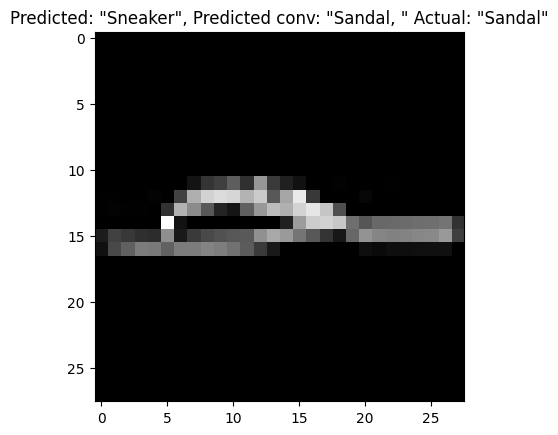

In [14]:
import matplotlib.pyplot as plt

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

idx = 8
model.eval()
conv_net.eval()

x, y = test_data[idx][0], test_data[idx][1]
with torch.no_grad():
    x = x.to(device)
    img = x.squeeze().cpu().numpy()
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]

    pred_conv = conv_net(x.unsqueeze(0))  # Add another dimension for batch with "unsqeeze"
    predicted_conv = classes[pred_conv[0].argmax(0)]

    plt.imshow(img, cmap="gray")
    plt.title(f'Predicted: "{predicted}", Predicted conv: "{predicted_conv}, " Actual: "{actual}"')

In [15]:
64 * 7 * 7

3136

In [16]:
conv_net(x)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x49 and 3136x512)

In [ ]:
x.shape

In [17]:

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

def build_conf_matrix(pt_model,dataloader, data_classes):
  y_pred = []
  y_true = []
# iterate over test data
  for inputs, labels in dataloader:
      output = pt_model(inputs) # Feed Network
      output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
      y_pred.extend(output) # Save Prediction
      labels = labels.data.cpu().numpy()
      y_true.extend(labels) # Save Truth

      # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / numpy.sum(cf_matrix, axis=1)[:, None],
                           index = [i for i in classes],
                           columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)

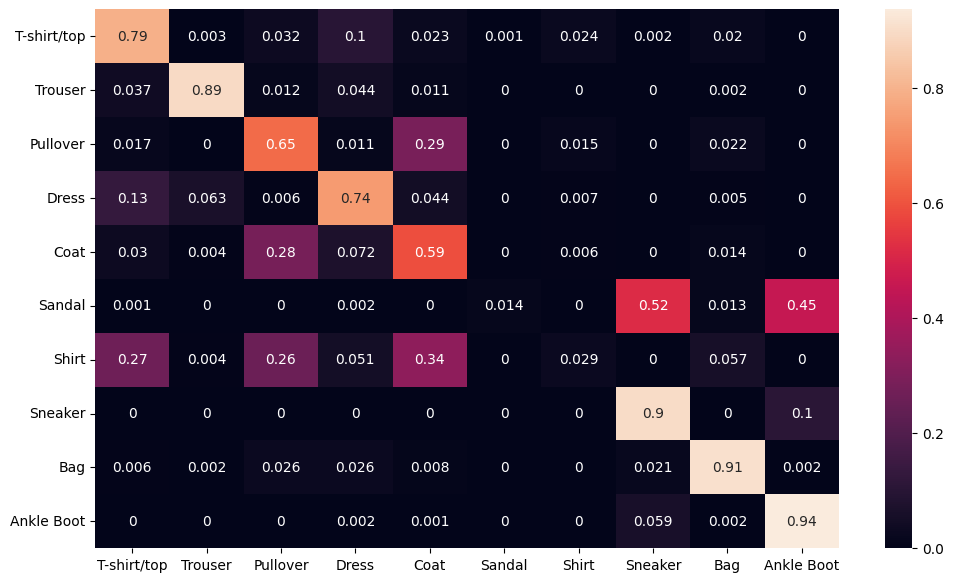

In [18]:
build_conf_matrix(model, test_dataloader, classes)

 Эта модель путает класс Coat

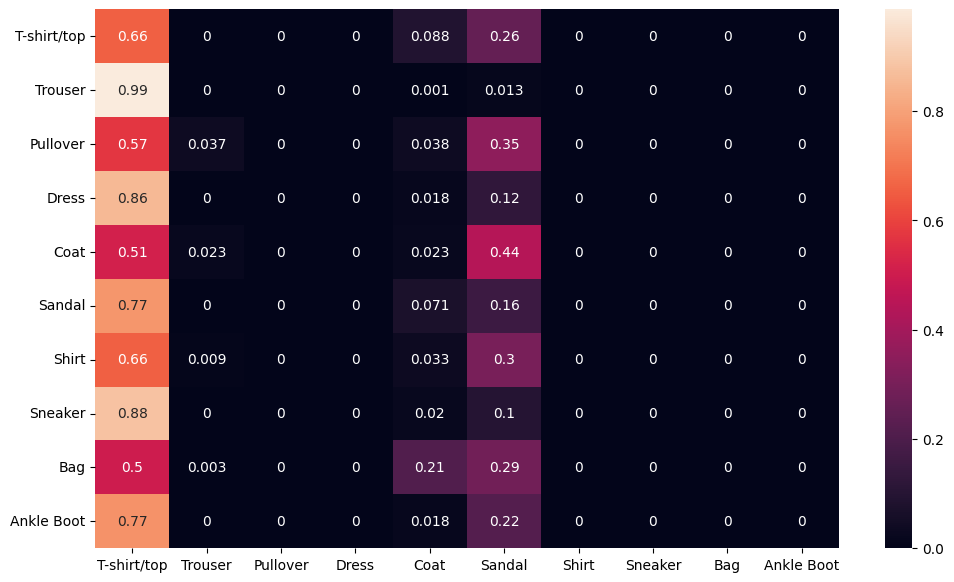

In [19]:
build_conf_matrix(model_2, test_dataloader, classes)

 Модель номер 2 в основном путает класс T-short.


------------------------------------------------------------------------


Saving Models
=============

A common way to save a model is to serialize the internal state
dictionary (containing the model parameters).


In [22]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")
torch.save(model_2.state_dict(), "model.pth")
print("Saved PyTorch Model State to model_2.pth")

Saved PyTorch Model State to model.pth
Saved PyTorch Model State to model_2.pth


Loading Models
==============

The process for loading a model includes re-creating the model structure
and loading the state dictionary into it.


In [23]:
model = NeuralNetwork(linear_relu_stack_1).to(device)
model.load_state_dict(torch.load("model.pth"))

RuntimeError: Error(s) in loading state_dict for NeuralNetwork:
	Unexpected key(s) in state_dict: "linear_relu_stack.6.weight", "linear_relu_stack.6.bias", "linear_relu_stack.8.weight", "linear_relu_stack.8.bias". 
	size mismatch for linear_relu_stack.0.weight: copying a param with shape torch.Size([1024, 784]) from checkpoint, the shape in current model is torch.Size([512, 784]).
	size mismatch for linear_relu_stack.0.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for linear_relu_stack.2.weight: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for linear_relu_stack.2.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for linear_relu_stack.4.weight: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([10, 512]).
	size mismatch for linear_relu_stack.4.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([10]).

This model can now be used to make predictions.


Read more about [Saving & Loading your
model](saveloadrun_tutorial.html).


In [82]:
import urllib.request
import numpy as np


from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

url = 'https://raw.githubusercontent.com/svgen83/ml_python_blastim/main/Pokemon.csv'
resp = urllib.request.urlopen(url)

pokemon = pd.read_csv(resp)

pokemon.head(3)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


In [91]:
X = pokemon[["Total", "HP", "Attack",'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation' ]]
Y = pokemon.Legendary.replace({True:1, False :0})

In [96]:
y_tensor = torch.from_numpy(Y.values.reshape(-1, 1)).float()
X_tensor = torch.from_numpy(X.values).float()
# нормирование данных
x_tensor = (X_tensor - X_tensor.mean(axis=0)) / X_tensor.std(axis=0)

In [98]:
def logistic(z):
    return 1 / (1 + torch.exp(-z))

def logistic_reg_model(X, w, b):
    return logistic(X @ w.t() + b)

def binary_cross_entropy(predicted, true):
    return -(true * predicted.log() + (1 - true) * (1 - predicted).log()).mean()

In [100]:
epochs = 1000
learning_rate = 0.001

# инициализируем параметры нулями
# и начинаем записывать историю вычислений
weight = torch.zeros(y_tensor.shape[1], x_tensor.shape[1], requires_grad=True)
bias = torch.zeros(y_tensor.shape[1], requires_grad=True)


for epoch in range(epochs):
    # forward pass — вычисляем функцию потерь
    predictions = logistic_reg_model(x_tensor, weight, bias)
    loss = binary_cross_entropy(predictions, y_tensor)
    # backward paass — вычисляем градиент
    loss.backward()
    # вычитаем производные из параметров
    # записывать историю вычислений уже не нужно (no_grad)
    with torch.no_grad():
        weight -= weight.grad * learning_rate
        bias -= bias.grad * learning_rate
        # обнуляем производные
        weight.grad.zero_()
        bias.grad.zero_()

predictions = logistic_reg_model(x_tensor, weight,bias)
print(roc_auc_score(y_tensor, predictions.detach().numpy()))

0.9736577708006279


In [101]:
class LogisticRegressionTorch(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegressionTorch, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, X):
        predictions = self.linear(X)
        return torch.sigmoid(predictions)

model3 = LogisticRegressionTorch(x_tensor.shape[1], y_tensor.shape[1])
# определяем функцию потерь — бинарную кросс-энтропию
criterion = nn.BCELoss()
# определяем алгоритм оптимизации Adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model3(x_tensor)
    loss = criterion(predictions, y_tensor)
    # вычисляем градиенты
    loss.backward()
    # обновляем параметры
    optimizer.step()

predictions = model3(x_tensor)

print(roc_auc_score(Y, predictions.detach().numpy()))

0.9580847723704866
